# <center>Recommender System project</center>
   <center>By Rekha Puttaswamy and Venkatesh Jeyaraj</center>


### Option 1 : Prod2Vec
Prod2Vec is a famous method in recommender systems allowing to compute similarities of products. It is basically a Word2Vec applied to the history of a user. 

### Expected deliverables :

• A notebook running prod2vec on a public dataset (you are free to take a word2vec code and customize it)

• A test showing that your algorithms is functional 

• Prediction results on your dataset

### Reference paper : </h3> https://arxiv.org/pdf/1606.07154.pdf 

### Use Case: 
We are modelling a recommendation system that predicts the user's preference of a movie based on his previous ratings on similar kind of movies.

### Loading the data from data set
- Loading data from csv file
- Converting Categorical column to numeric
- Separating test and train data

In [21]:
import keras
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

In [22]:
# Get the data
df_ = pd.read_csv('ratings.csv')
df = df_[['movieId','userId','rating','timestamp']]

#count how many Movies and Users we have
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
n_ratings=len(df.rating.unique())

print('n_movies:',n_movies,'/ n_users:',n_users,' / n_ratings:', n_ratings)

n_movies: 9724 / n_users: 610  / n_ratings: 10


In [23]:
#replace Nan by -1
df['rating'] = df['rating'].fillna(-1) 

print('remove',len(df[df['rating']==-1]),'rows / ',len(df))
df = df[df['rating']>-1] 

remove 0 rows /  100836


In [24]:
movieId = df.movieId.sort_values().unique()
print('last id for Movie',np.max(movieId))

userId = df.userId.sort_values().unique()
print('last id for User',np.max(userId))

last id for Movie 193609
last id for User 610


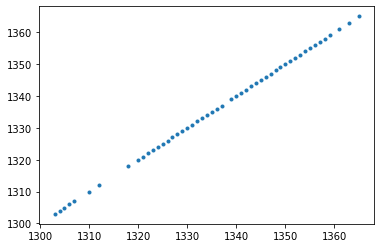

In [25]:
# Plot the repartition of the pks
lim = 50
start = 1000

plt.plot(movieId[start:start+lim],movieId[start:start+lim],'.')
plt.show()

In [26]:
#For Movies

#what we have
K = list(movieId)

#Our objective
V = list(range(0,len(movieId))) 

#dictionary that links old ids to new ids
mapping = dict(zip(K, V)) 

#apply this mappings to the column
df['movieId'] = df['movieId'].apply(lambda x: mapping[x]) 

In [27]:
#For Users
#what we have
K_ = list(userId) 

#Our objective
V_ = list(range(0,len(userId)))

#dictionary that links old ids to new ids
mapping_ = dict(zip(K_, V_)) 

#apply this mappings to the column
df['userId'] = df['userId'].apply(lambda x: mapping_[x]) 

In [28]:
movieId = df.movieId.sort_values().unique()
print('last id for Movies',np.max(movieId))

userId = df.userId.sort_values().unique()
np.max(userId)
print('last id for Users',np.max(userId))

last id for Movies 9723
last id for Users 609


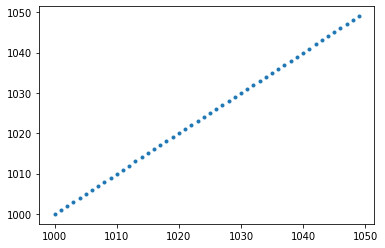

In [29]:
# Plot the repartition of the pks
lim = 50
start = 1000
plt.plot(movieId[start:start+lim],movieId[start:start+lim],'.')
plt.show()

In [30]:
#drop useless columns
df_keras = df[['movieId','userId','rating']]

#train/test split
train, test = train_test_split(df_keras, test_size=0.2, random_state=1)

n_users = len(df.userId.unique())
n_movies = len(df.movieId.unique())

### Creating Embedding Model
The Keras deep learning framework makes it easy to create neural network embeddings as well as working with multiple input and output layers.

Our model will have the following structure:
Input: Input for both movies and users
Embedding Layers: Embeddings for movies and users
Dot: combines embeddings using a dot product

In [31]:
embedding_dimensions = 20

In [32]:
#1/ embed the movieId
movie_input = Input(shape=[1], name="Movie-Input") # the input is a scalar (the id)
movie_embedding = Embedding(n_movies+1, embedding_dimensions, name="Movie-Embedding")(movie_input) #embedd in low dimensions space
movie_vec = Flatten(name="Flatten-Movie")(movie_embedding) # make a vector of it

#2/ embed the userId
user_input = Input(shape=[1], name="User-Input") # the input is a scalar (the id)
user_embedding = Embedding(n_users+1, embedding_dimensions, name="User-Embedding")(user_input) #embedd in low dimensions space
user_vec = Flatten(name="Flatten-User")(user_embedding ) # make a vector of it

#3/ dot product between the two embeddings
output = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec ]) 

In [33]:
#define model and compile
model = Model([user_input, movie_input], output)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae', 'acc'])

### Training the model
Because we have two input layers for movies and users, we need to specify an array of training data as our x data. We are training the model for 20 epochs

In [34]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=20, validation_split=0.25, verbose=1)

Train on 60501 samples, validate on 20167 samples
Epoch 1/20
60501/60501 [==============================] - 13s 223us/step - loss: 11.2950 - mean_absolute_error: 3.1579 - acc: 0.0094 - val_loss: 5.9242 - val_mean_absolute_error: 2.1267 - val_acc: 0.0632
Epoch 2/20
60501/60501 [==============================] - 18s 303us/step - loss: 3.5122 - mean_absolute_error: 1.5148 - acc: 0.1414 - val_loss: 2.5443 - val_mean_absolute_error: 1.2284 - val_acc: 0.1920
Epoch 3/20
60501/60501 [==============================] - 14s 239us/step - loss: 1.7813 - mean_absolute_error: 1.0159 - acc: 0.2354 - val_loss: 1.8433 - val_mean_absolute_error: 0.9998 - val_acc: 0.2454
Epoch 4/20
60501/60501 [==============================] - 15s 249us/step - loss: 1.2406 - mean_absolute_error: 0.8393 - acc: 0.2769 - val_loss: 1.5706 - val_mean_absolute_error: 0.9036 - val_acc: 0.2704
Epoch 5/20
60501/60501 [==============================] - 15s 247us/step - loss: 0.9927 - mean_absolute_error: 0.7556 - acc: 0.2978 - val

In [35]:
#save model
model.save('regression_model.h5')

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


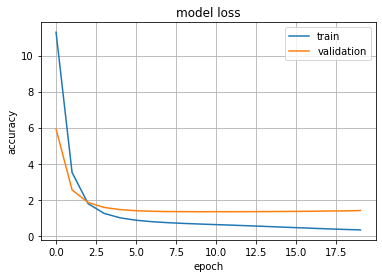

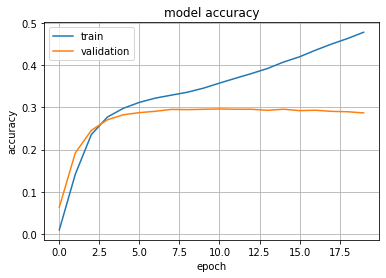

In [36]:
#LOSS PLOT
print(history.history.keys())
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid()
plt.show()

# summarize history for accuracy
plt.close()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid()
plt.show()

In [37]:
# Extract embeddings
movie_em = model.get_layer('Movie-Embedding') #this is after the embedding layer
movie_em_weights = movie_em.get_weights()[0] 

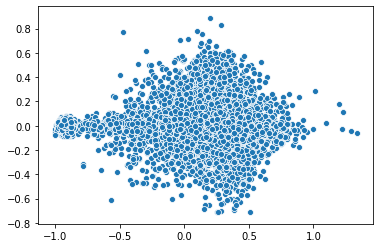

In [38]:
# PCA : plot track embeddings in 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(movie_em_weights)
plt.close()
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

### Visualizing embeddings
We are using Embeddings to visualize the relation of different movies. For this we need to reduce dimensionality using dimensionality reduction techniques like principal component analysis (PSA) or t-distributed stochastic neighbor embedding (TSNE).

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9725 samples in 0.038s...
[t-SNE] Computed neighbors for 9725 samples in 9.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9725
[t-SNE] Computed conditional probabilities for sample 2000 / 9725
[t-SNE] Computed conditional probabilities for sample 3000 / 9725
[t-SNE] Computed conditional probabilities for sample 4000 / 9725
[t-SNE] Computed conditional probabilities for sample 5000 / 9725
[t-SNE] Computed conditional probabilities for sample 6000 / 9725
[t-SNE] Computed conditional probabilities for sample 7000 / 9725
[t-SNE] Computed conditional probabilities for sample 8000 / 9725
[t-SNE] Computed conditional probabilities for sample 9000 / 9725
[t-SNE] Computed conditional probabilities for sample 9725 / 9725
[t-SNE] Mean sigma: 0.070582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.874992
[t-SNE] KL divergence after 300 iterations: 3.346135


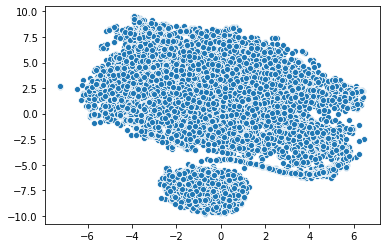

In [39]:
# TSNE : plot track embeddings in 2 dimensions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(movie_em_weights)
plt.close()
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

In [40]:
# Extract embeddings
user_em = model.get_layer('User-Embedding') #this is after the embedding layer
user_em_weights = user_em.get_weights()[0] 

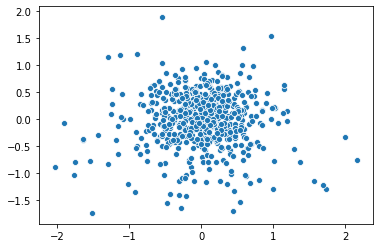

In [41]:
# PCA : plot track embeddings in 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_em_weights)
plt.close()
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 611 samples in 0.001s...
[t-SNE] Computed neighbors for 611 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 611 / 611
[t-SNE] Mean sigma: 0.440200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.204453
[t-SNE] KL divergence after 300 iterations: 1.738932


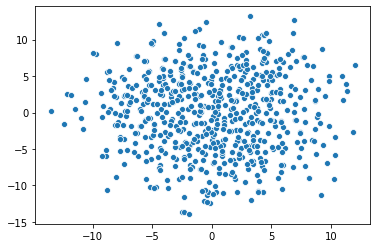

In [42]:
# TSNE : plot track embeddings in 2 dimensions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(user_em_weights)
plt.close()
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

### Making Recommendations
We are now making recommendations using our trained model for the first user. We are using movie dataset to make the predictions

In [52]:
# Creating dataset for making recommendations for the first user
movie_data = np.array(list(set(df.movieId)))
user = np.array([1 for i in range(len(movie_data))])
predictions = model.predict([user, movie_data])
predictions = np.array([a[0] for a in predictions])
recommended_Movie_id = (-predictions).argsort()[:5]
print(recommended_Movie_id)
print(predictions[recommended_Movie_id])

[4588 8943 3500 5042 7603]
[6.73407   6.5770683 6.533502  6.32532   6.2841945]


In [46]:
Movies = pd.read_csv('movie.csv')
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [47]:
print(Movies[Movies['movieId'].isin(recommended_Movie_id)])

      movieId                                           title          genres
3410     3500                       Mr. Saturday Night (1992)    Comedy|Drama
4493     4588  Eddie and the Cruisers II: Eddie Lives! (1989)   Drama|Musical
4946     5042                           Forbidden Zone (1980)  Musical|Sci-Fi
8260     8943                              Being Julia (2004)    Comedy|Drama


### Evaluation Matrix
We are using Root mean squared error (RMSE) and Mean Absolute Error (MAE) evalution metrics to measure accuracy for continuous variables in our model.

In [49]:
import pandas as pd
from surprise import SVD
from surprise import KNNBaseline
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

In [54]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_keras[['userId', 'movieId', 'rating']], reader)

train, test = train_test_split(data, test_size=0.25, random_state=1)

algo = SVD(random_state=0)
algo.fit(train)
predictions = algo.test(test)

def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
print("RMSE: ", RMSE(predictions))
print("MAE: ", MAE(predictions))

RMSE:  0.8800950930093621
MAE:  0.675733544076352


### Conclusion
We used Embeddings for finding similarities of the type of movies that can be recommended to a user. 
We plotted graphs to find the accuracy of the model
We calculated both MAE and RMSE express average model prediction error in units of the variable of interest.
Since the RMSE value is close to 1, our model can be considered as highly accurate.

In general, when cosine similarity and TFIDF algorithm is applied in the vector space for the recommender system of  content based filtering, RMSE value is approxiamately 2.4899 which is high compared to the neural network embeddings used here. Hence Neural networks embedded model used in this example is more accurate.